# Think Bayes: Chapter 14

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from itertools import product
from IPython.display import display
from scipy import stats
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb

'Done'

'Done'

## Geiger Counter Problem

Variables

- $r$: average rate at which some source emits particles (particles / second).
- $n$: number of particles emitted (particles / second).
- $f$: the fraction of particles counted by a counter (e.g. 10 %)
- $k$: the number of particles that were counted.

Distributions

- $n$ is Poisson-distributed with parameter $r$. This gets more complicated if $r$ is a distribution, but still doable.
- $k$ is Binomial-distributed with parameters $n$ and $f$.

Forward and Inverse Problems

- Forward problem: given the parameters of the system, find the distribution of the data.
- Inverse problem: given the data, find the distributions of the parameters.

Simple Model

- Assume we know fixed values of $r$ and $f$.
- Estimate $n$.

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.85 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.77 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.73 ms


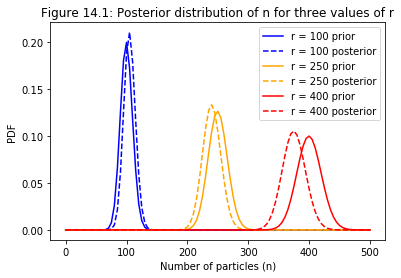

In [6]:
class SimpleCounter(mtb.PMF):
    
    def __init__(self, r, f, N):
        
        # SimpleCounter represents the distribution of n,
        # the number of particles emitted. This starts with
        # a Poisson prior with parameter r.
        hypos = N
        probs = stats.poisson.pmf(hypos, mu=r)
        super().__init__(hypos, probs)
        
        self.r = r
        self.f = f
        
    def update(self, data, normalize=True):
        """Vectorized update function. ~20x faster than using the looping update.
        
        The likelihood P(data | hypo) is the Binomial probability that *data* particles
        were counted using a counter with accuracy *self.f* given *hypo* particles emitted.
        
        The scipy stats library lets you comptue the Binomial PMF for all values of N
        in one call. This is the "vectorized" part that spees things up.
        
        I left the slower likelihood function for comparison.
        
        # Arguments:
            data: number of particles counted.
            normalize: whether to normalize before returning.
        
        # Returns:
            self
        
        """
        
        k = data
        N = self.hypos
        p = self.f
        
        Like = stats.binom.pmf(k, N, p)
        self[:] *= Like
        
        if normalize:
            return self.normalize()
        return self
        
    def likelihood(self, data, hypo):
        """P(data | hypo) is the Binomial probability that *data* particles
        were counted given *hypo* particles emitted and Binomial parameter
        self.f (can be interpretted as accuracy of the counter).
        
        # Arguments:
            data: number of particles detected.
            hypo: hypothetical number of particles emitted.
        
        # Returns:
            like: scalar likelihood.
        """
        k = data
        n = hypo
        p = self.f
        return stats.binom.pmf(k, n, p)
        
        
# Test the model for a fixed f, fixed data, and variable r.
f = 0.1
k = 15
N = np.arange(0, 501, 5)

for r, c in zip([100, 250, 400], ['blue', 'orange', 'red']):
    sc = SimpleCounter(r, f, N)
    sc.plot(label='r = %d prior' % r, color=c)
    %time sc.update(k)
    sc.plot(label='r = %d posterior' % r, color=c, linestyle='--')
    
plt.title('Figure 14.1: Posterior distribution of n for three values of r')
plt.xlabel('Number of particles (n)')
plt.ylabel('PDF')
plt.legend()
plt.show()

## Make it hierarchical

Changes

- No longer assuming a fixed value for $r$, but rather a distribution of values for $r$, with a `SimpleCounter` object corresponding to each value of $r$.

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 93.2 ms
CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 187 ms


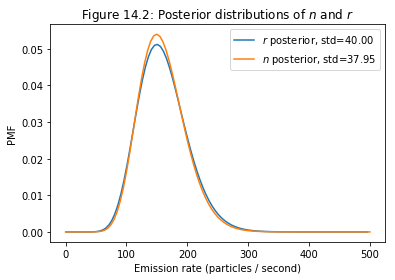

In [12]:
class EmissionRate(mtb.PMF):
    """Models r and n based on counters, one counter for each value of r.
    
    # Arguments:
        R: a range of values for r.
        N: a range of values for n.
        f: the proportion of particles counted by a counter.
    """
    
    def __init__(self, R, N, f=0.1):
        
        # Start with a uniform distribution over R values.
        # Downey simply makes the counter objects his hypotheses, but
        # PMF inherits from pandas.Series, and pandas.Series doesn't 
        # support using objects for the index.
        super().__init__(R)
        
        # Keep a counter for each value of r in a dict.
        self.counters = {r: SimpleCounter(r, f, N) for r in R}
        
    @property
    def n(self):
        """Return the distribution of n, which is a mixture over the counters'
        distributions of n weighted by each counter's probability."""
        pmfs = [(self.counters[r], prob) for r, prob in self.items()]
        return mtb.PMF.from_mixture(pmfs)
    
    def likelihood(self, data, hypo):
        """P(data | hypo) = P(counted k particles | emission rate r).
        
        The likelihood that gets returned is the sum of the unnormalized posterior
        from updating the counter corresponding to r.
        """
        
        k = data
        r = hypo
        
        # Update the counter without normalizing and get its sum.
        like = self.counters[r].update(k, normalize=False).sum()
        
        # Now normalize the counter.
        self.counters[r].normalize()
        
        return like
            
%time er = EmissionRate(R=np.arange(1, 501, 5), N=np.arange(0, 501, 5), f=0.1)
%time er.update(15)

er.plot(label='$r$ posterior, std=%.2lf' % np.sqrt(er.var()))

n = er.n
n.plot(label='$n$ posterior, std=%.2lf' % np.sqrt(n.var()))

plt.xlabel('Emission rate (particles / second)')
plt.ylabel('PMF')
plt.title('Figure 14.2: Posterior distributions of $n$ and $r$')
plt.legend()
plt.show()

A note on Downey's interpretation of the posteriors.

> The posterior distributions of r and n are similar; the only difference is that
we are slightly less certain about n. In general, we can be more certain about the
long-range emission rate, r, than about the number of particles emitted in any
particular second, n.

The plot and the variance measured on both posteriors seem to contradict Downey's
interpretation. $n$ has standard deviation $\sigma(n) \approx 37.95$, while $\sigma(r) \approx 40$.
This would indicate we are actually *more* certain about $n$ than $r$. However, he
seems to have left out this example entirely in the ThinkBayes2 repository, so maybe
there were other problems as well.